In [17]:
import os
import resource
import psutil

memory_limit = 16 * 1024 * 1024 * 1024  # 16GB in bytes
resource.setrlimit(resource.RLIMIT_AS, (memory_limit, memory_limit))

# Restrict CPU core usage
p = psutil.Process()  
p.cpu_affinity([0, 1, 2, 3])  

In [18]:
import tensorflow as tf
import psutil
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import time
import matplotlib.pyplot as plt

tf.config.set_visible_devices([], 'GPU')

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'



Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU Count: 256


In [19]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the GPT-2 model and tokenizer
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

input_text = "Hello, how are you?"
inputs = tokenizer(input_text, return_tensors="pt").to(device)
outputs = quantized_model.generate(**inputs)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))





Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Hello, how are you?

The, the, the, the, the, the, the, the, the,


In [20]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as the pad_token

quantized_model.eval()  # Set model to evaluation mode

prompt = "What is the capital of Denmark?"

inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Ensure padding is applied if needed

attention_mask = inputs['attention_mask']

In [21]:
def measure_latency(tokenizer, model, prompt, iterations=25):
    latencies = []
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Encode the prompt with padding
    attention_mask = inputs['attention_mask']  # Get the attention mask
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    start_time = time.time()
    quantized_model.generate(
        inputs['input_ids'], 
        attention_mask=attention_mask,  # Pass the attention mask
        max_length=50,
        pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
    )
    end_time = time.time()
    # Calculate latency
    latency = end_time - start_time
    return latency

latency = measure_latency(tokenizer, model, prompt)
print(f"Average Latency: {latency * 1000:.2f} ms")



Average Latency: 1269.86 ms


Average Throughput: 2.46 samples/second


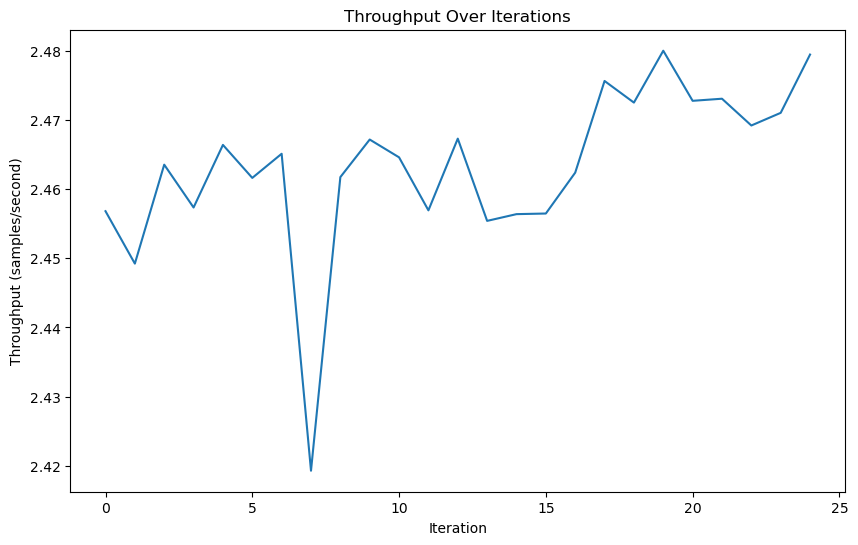

In [15]:
def measure_throughput(tokenizer, model, prompt, batch_size=8, iterations=25):
    throughputs = []
    inputs = tokenizer([prompt] * batch_size, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
    attention_mask = inputs['attention_mask']
    
    # Set  to eos_token_id if necessary
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    for _ in range(iterations):
        start_time = time.time()
        quantized_model.generate(
            inputs['input_ids'], 
            attention_mask=attention_mask,  # Pass the attention mask
            max_length=50,
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        end_time = time.time()
        throughput = batch_size / (end_time - start_time)
        throughputs.append(throughput)
    
    average_throughput = sum(throughputs) / len(throughputs)
    return throughputs, average_throughput

# Measure and  average throughput
prompt = "Mary had a little lamb"
throughputs, average_throughput = measure_throughput(tokenizer, model, prompt)
print(f"Average Throughput: {average_throughput:.2f} samples/second")

plt.figure(figsize=(10, 6))
plt.plot(throughputs)
plt.title('Throughput Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Throughput (samples/second)')
plt.show()

Average Memory Usage: 26107.06 MB


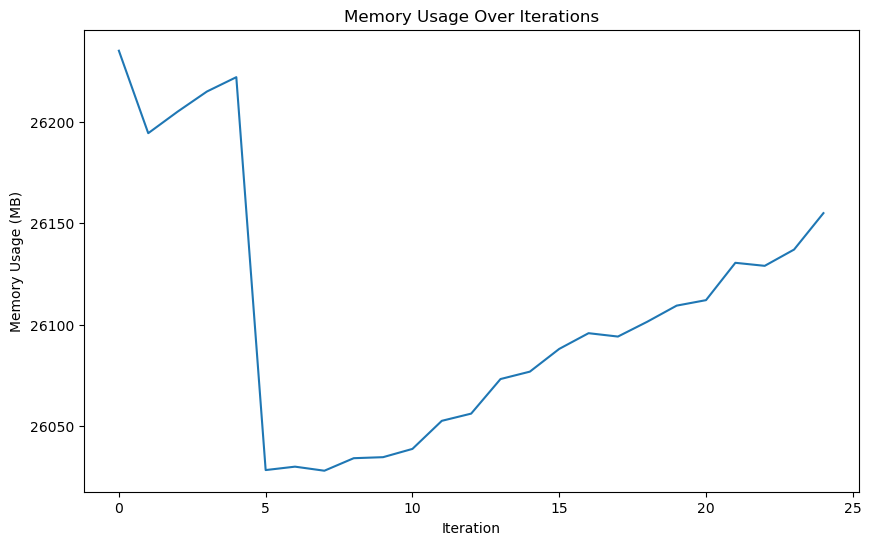

In [16]:
def get_memory_usage():
    memory = psutil.virtual_memory()
    return memory.used  # Return memory used in bytes

def track_memory_usage(model, inputs, attention_mask, iterations=25):
    memory_usages = []
    for _ in range(iterations):
        outputs = quantized_model.generate(
            inputs['input_ids'],
            attention_mask=attention_mask,  
            max_length=100,  #
            num_return_sequences=1,  
            no_repeat_ngram_size=2,  
            top_p=0.92,  
            top_k=50,  
            temperature=0.85,  #
            do_sample=True,  
            pad_token_id=tokenizer.pad_token_id  #
        )
        memory_usage = get_memory_usage()
        memory_usages.append(memory_usage)
    
    average_memory_usage = sum(memory_usages) / len(memory_usages)
    return memory_usages, average_memory_usage

# Define inputs and attention mask
prompt = "What is the capital of Denmark and what is the capital of India?"
inputs = tokenizer(prompt, return_tensors="pt", padding=True)
attention_mask = inputs['attention_mask']

# Track memory usage over iterations
memory_usages, average_memory_usage = track_memory_usage(model, inputs, attention_mask)

# Print average memory usage
print(f"Average Memory Usage: {average_memory_usage / (1024 * 1024):.2f} MB")

# Plot memory usage over iterations
plt.figure(figsize=(10, 6))
plt.plot([usage / (1024 * 1024) for usage in memory_usages])  # Convert bytes to MB for plotting
plt.title('Memory Usage Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Memory Usage (MB)')
plt.show()
